In [2]:
import sys
import os
import mowgli
import mudata as md
import scanpy as sc

# Load data into a Muon object.
import muon as mu
from muon import MuData
import numpy as np
import matplotlib.pyplot as plt
import os
from mowgli import models
import torch
import leidenalg



/home/zuzanna/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:


data_dir = "/home/zuzanna/data/"  # Path to the mounted data directory
# Load the data.
mdata_TEA = mu.read_h5mu(data_dir + "100_tea_preprocessed.h5mu.gz")

# Initialize and train the model.
# Define the model.
model = mowgli.models.MowgliModel(latent_dim=15)


/home/zuzanna/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/zuzanna/miniconda3/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [4]:

# Train the model
boo = torch.cuda.is_available()
if boo:
        print("GPU available")
        device=torch.device("cuda:0")


GPU available


In [5]:
model.train(mdata_TEA, device=device, optim_name='sgd', lr=0.01, tol_inner=1e-5)
#Save model and losses
np.save(data_dir +"mowgli_GSM4949911.npy",
    {
        "W": mdata_TEA.obsm["W_OT"],
        **{"H_" + mod: mdata_TEA[mod].uns["H_OT"] for mod in mdata_TEA.mod},
        "loss_overall": model.losses,
        "loss_w": model.losses_w,
        "loss_h": model.losses_h
    },
    )

  2%|▏         | 4/200 [00:07<05:51,  1.79s/it, loss=-0.3948083, mass_transported=0.0772, loss_inner=0.16476806, inner_steps=0, gpu_memory_allocated=2.44e+9] 


In [6]:
#Load embeddings
X_mowgli = np.load(data_dir+"mowgli_GSM4949911.npy", allow_pickle=True).item()["W"]
mdata_TEA.obsm["X_mowgli"] = X_mowgli
mdata_TEA.uns = {}



/home/zuzanna/miniconda3/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


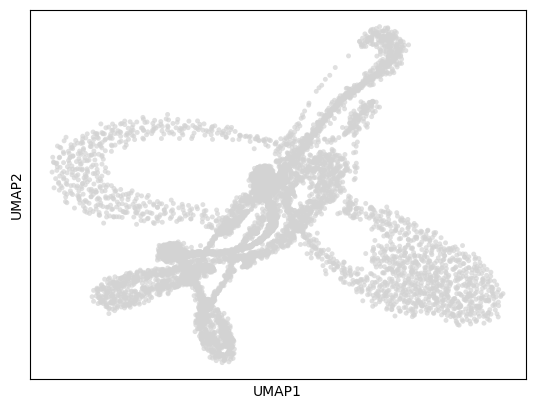

In [7]:
#Save umap
sc.pp.neighbors(mdata_TEA, use_rep="X_mowgli", n_neighbors=20)
sc.tl.umap(mdata_TEA)
sc.pl.umap(mdata_TEA, size=50, alpha=0.7)


/tmp/ipykernel_31213/624195148.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(mdata_TEA)


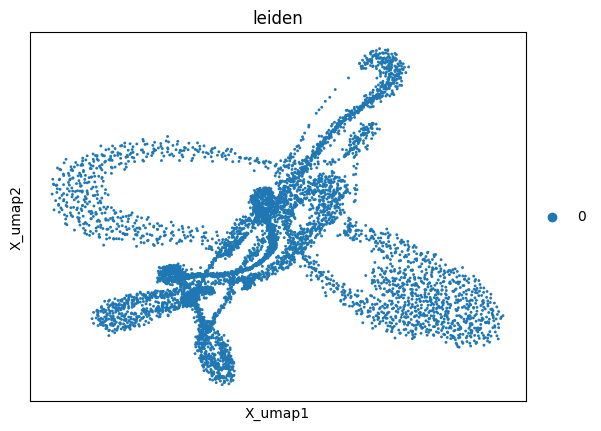

In [8]:

#leiden
sc.tl.leiden(mdata_TEA)
sc.pl.embedding(mdata_TEA, "X_umap", color=['leiden'])


In [9]:
# print(X_mowgli.shape)
# print(X_mowgli[:5])

In [10]:
# print("Overall Loss:", model.losses)
# print("W Loss:", model.losses_w)
# print("H Loss:", model.losses_h)
